In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import os

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
from xskillscore import rmse

warnings.filterwarnings("ignore")

## Getting Data Ready

In [2]:
# Get all best model results for validation
files = glob('results/final_results/*')

# split the files into mean and std
gp_means_fp = sorted([f for f in files if 'mean' in f])
gp_std_fp = sorted([f for f in files if 'std' in f])

In [3]:
variables = ['dtr', 'pr', 'pr90', 'tas'] # variables in alphabetical order

# Getting predictions from GP mean
gp_means_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_means_fp)
}

# Getting predictions from GP std
gp_std_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_std_fp)
}

In [4]:
# Get data from Reproduction
files = glob('results/validations_from_reproduction/*')

# split the files into mean and std
gp_means_repo_fp = sorted([f for f in files if 'mean' in f])
gp_std_repo_fp = sorted([f for f in files if 'std' in f])

# Getting predictions from repo GP mean
gp_means_repo_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_means_repo_fp)
}

# Getting predictions from repo GP std
gp_std_repo_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_std_repo_fp)
}

In [5]:
# Get the observed data
Y = xr.open_dataset('results/final_results/outputs_ssp245.nc')

# rename diundamental temperature range to dtr for consistency
Y = Y.rename({'diurnal_temperature_range': 'dtr'})

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400
Y = Y.mean('member')
NorESM_data = {
    var: Y[var] for var in variables
}

## Making spatial plots

In [6]:
variables = ['tas', 'dtr', 'pr', 'pr90']
variables_names = ['Temperature', 'Diurnal temperature range', 'Precipitation', '90th percentile of precipitation']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
models = ['Deep Kernel Learning', 'Base GP (Reproduction)', 'NorESM2']
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

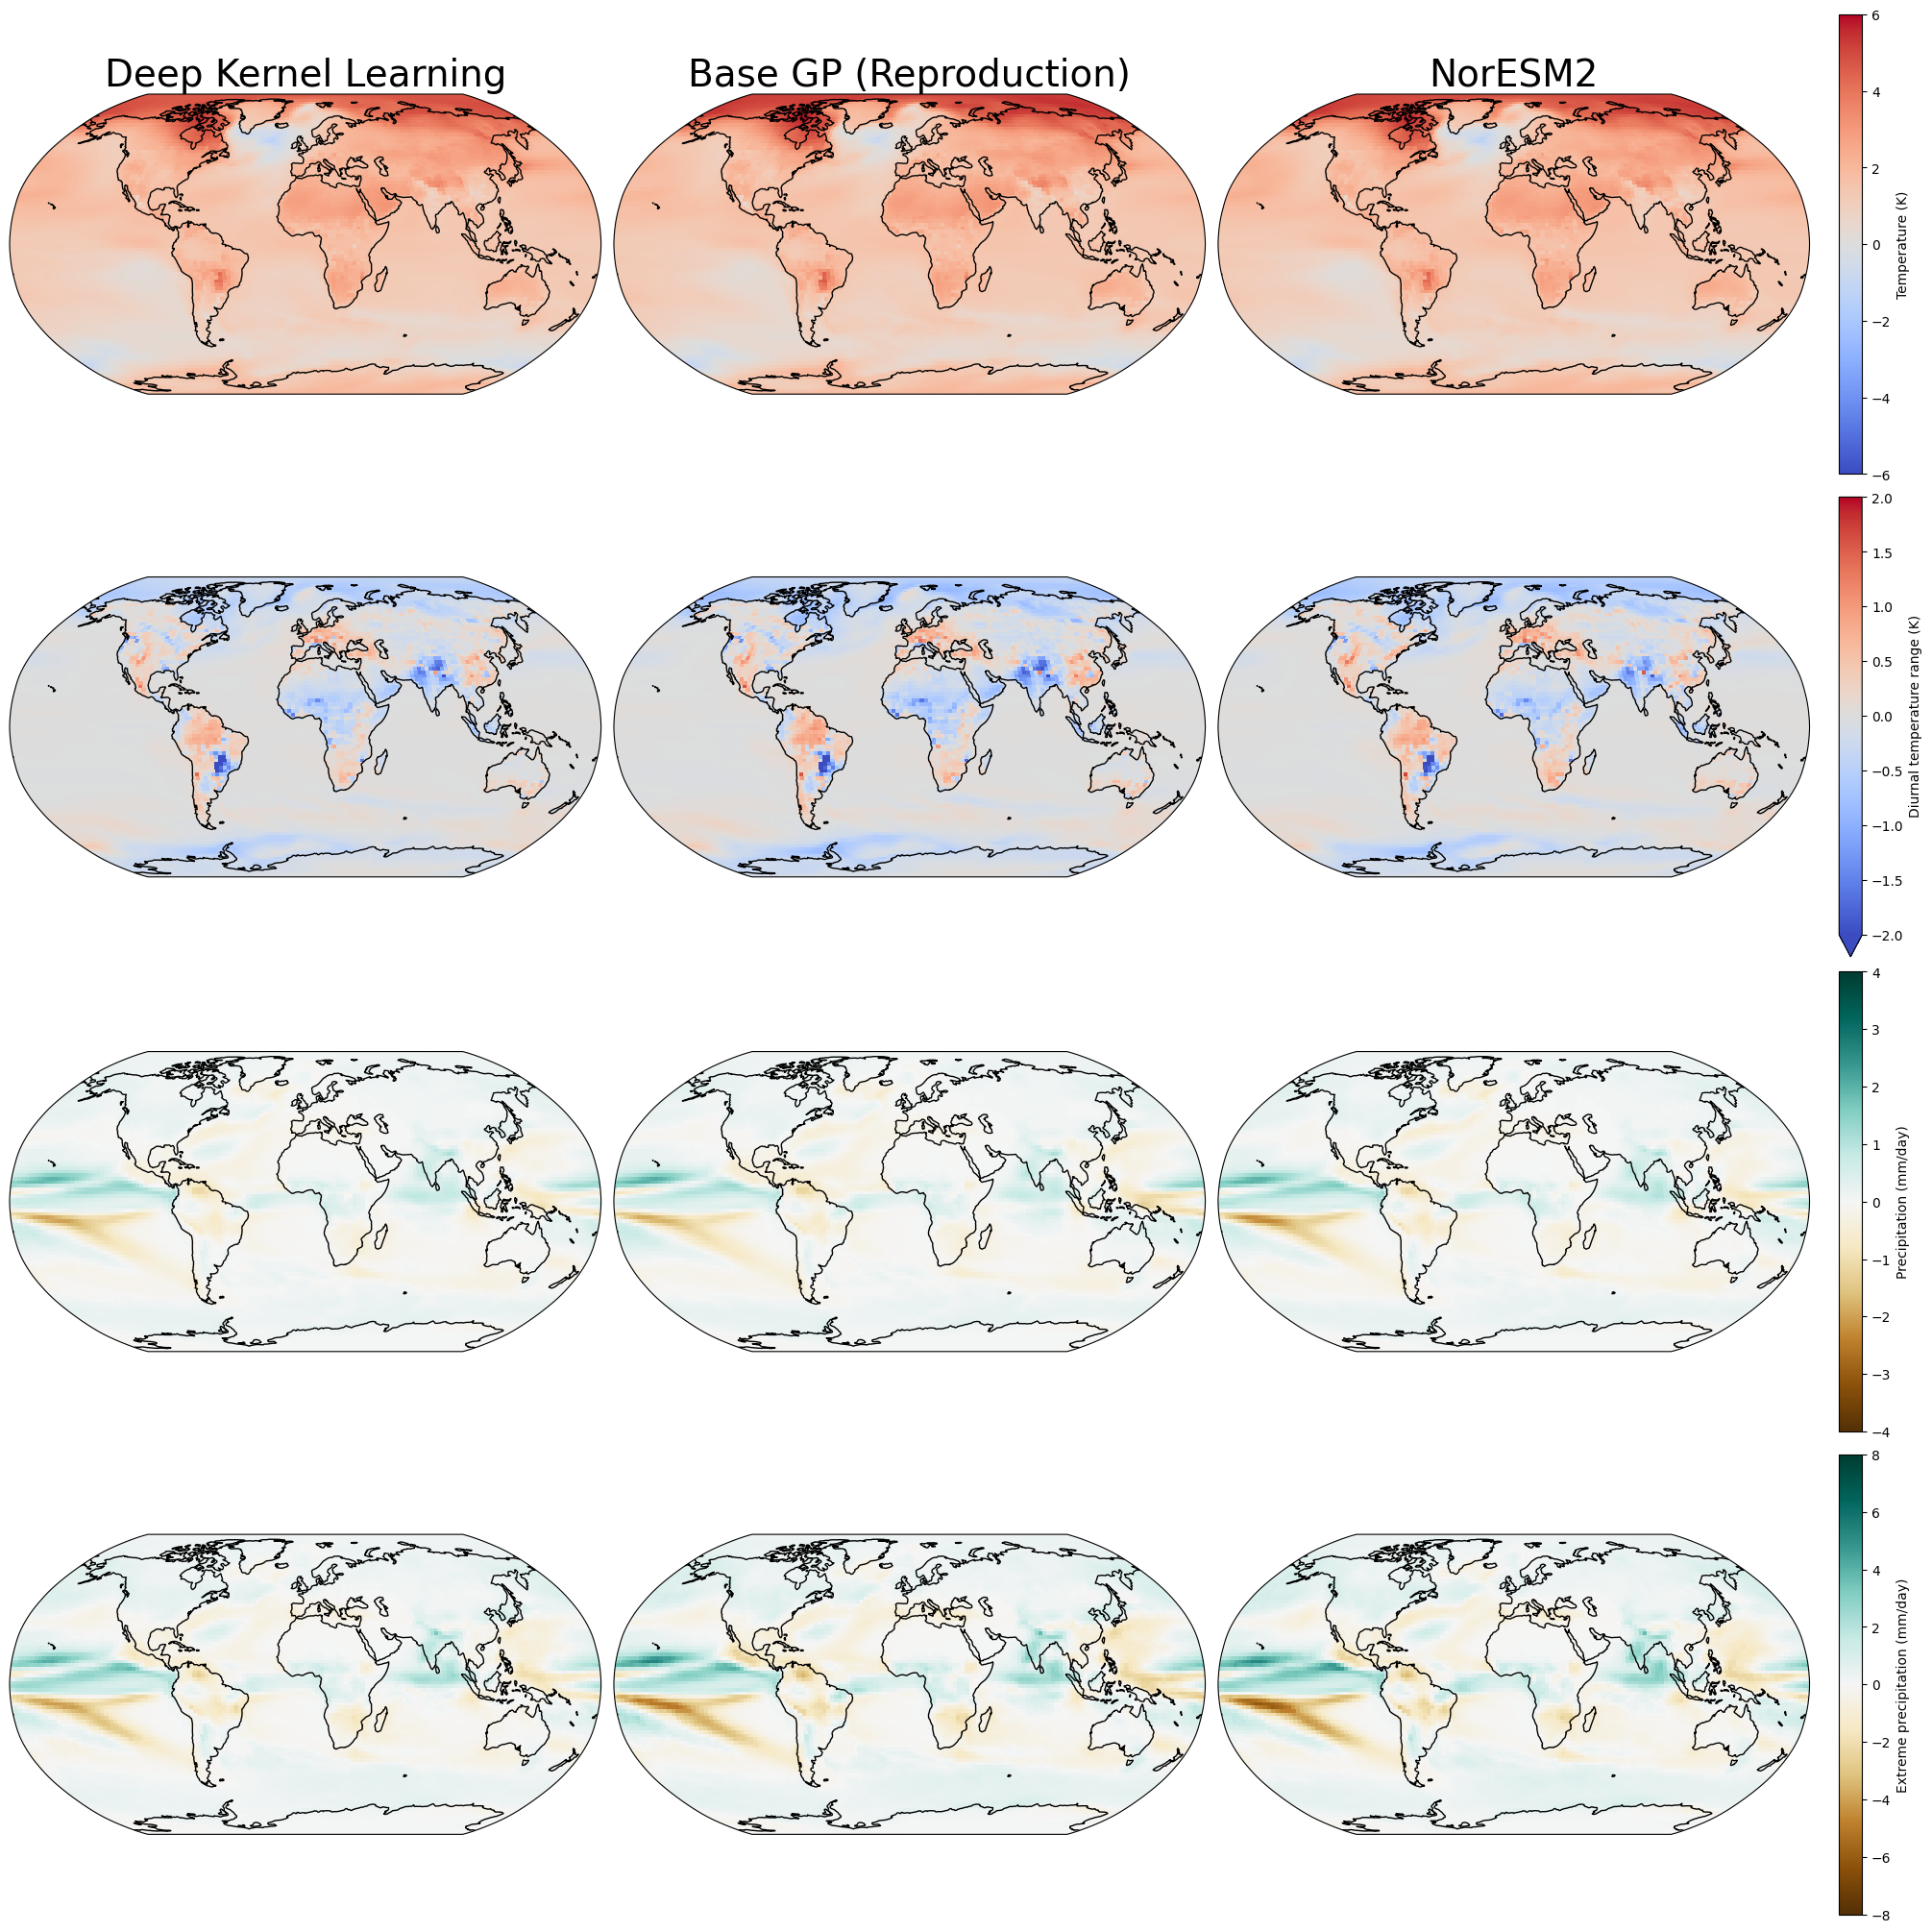

In [7]:
# Plot results one for each variable comparing with the observed data and reproduction 
fig, axes = plt.subplots(4, 3, figsize=(20, 20), subplot_kw={"projection": ccrs.Robinson()},constrained_layout=True)

for i, var in enumerate(variables):
    # Setting the axis 
    ax = axes[i, 0]
    for j, model in enumerate([gp_means_data, gp_means_repo_data, NorESM_data]):
        # Plotting the data
        if j == 2:
            model[var].mean(dim='time').plot(ax=axes[i, j], transform=ccrs.PlateCarree(), add_labels=False, cbar_kwargs={"label":labels[i], "orientation":'vertical'}, **kwargs[i])
        else:
            model[var].mean(dim='time').plot(ax=axes[i, j], transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, **kwargs[i])
        axes[i, j].coastlines()

    # Setting the title only on first row
    if i == 0:
        axes[i, 0].set_title("Deep Kernel Learning", fontsize=28)
        axes[i, 1].set_title("Base GP (Reproduction)", fontsize=28)
        axes[i, 2].set_title("NorESM2", fontsize=28)

## Evaluations Metrics

In [8]:
# Function to get different evaluation metrics
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # Calculate the weights
    weights = np.cos(np.deg2rad(truth.lat)).expand_dims(lon=144).assign_coords(lon=truth.lon)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(4)
    R2E = R2E.T.round(4)
    NRMSE = NRMSE.T.round(4)
    return R2E, NRMSE, total

In [9]:
eval_metrics_2080_2100 = {
    'Deep Kernel Learning': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
    'Base GP (Reproduction)': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
}
eval_metrics_2015_2100 = {
    'Deep Kernel Learning': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
    'Base GP (Reproduction)': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
}

for i, var in enumerate(variables):
    # Get the scores
    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_data[var])
    print(f"Deep Kernel Learning {var} R2E (2080-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2080_2100['Deep Kernel Learning'].loc[var] = [R2E, NRMSE, total]
    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_data[var], Yearslice=slice(2015, None))
    print(f"Deep Kernel Learning {var} R2E (2015-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2015_2100['Deep Kernel Learning'].loc[var] = [R2E, NRMSE, total]

    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_repo_data[var])
    print(f"Base GP (Reproduction) {var} R2E (2080-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2080_2100['Base GP (Reproduction)'].loc[var] = [R2E, NRMSE, total]
    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_repo_data[var], Yearslice=slice(2015, None))
    print(f"Base GP (Reproduction) {var} R2E (2015-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2015_2100['Base GP (Reproduction)'].loc[var] = [R2E, NRMSE, total]

    print("\n")

Deep Kernel Learning tas R2E (2080-2100): 0.0458, NRMSE: 0.0752, Total: 0.3044
Deep Kernel Learning tas R2E (2015-2100): 0.0667, NRMSE: 0.0531, Total: 0.3865
Base GP (Reproduction) tas R2E (2080-2100): 0.0437, NRMSE: 0.0906, Total: 0.3089
Base GP (Reproduction) tas R2E (2015-2100): 0.0587, NRMSE: 0.0694, Total: 0.3626


Deep Kernel Learning dtr R2E (2080-2100): 1.5602, NRMSE: 8.486, Total: 16.2872
Deep Kernel Learning dtr R2E (2015-2100): 0.399, NRMSE: 1.9205, Total: 3.9153
Base GP (Reproduction) dtr R2E (2080-2100): 2.6495, NRMSE: 9.195, Total: 22.4425
Base GP (Reproduction) dtr R2E (2015-2100): 0.629, NRMSE: 2.1638, Total: 5.3086


Deep Kernel Learning pr R2E (2080-2100): 0.3169, NRMSE: 2.4195, Total: 4.0041
Deep Kernel Learning pr R2E (2015-2100): 0.3949, NRMSE: 1.9935, Total: 3.9682
Base GP (Reproduction) pr R2E (2080-2100): 0.3784, NRMSE: 2.3301, Total: 4.2223
Base GP (Reproduction) pr R2E (2015-2100): 0.5539, NRMSE: 3.0496, Total: 5.8189


Deep Kernel Learning pr90 R2E (2080-2100

In [10]:
# Get difference between models total score
diff_2080_2100 = eval_metrics_2080_2100['Deep Kernel Learning'] - eval_metrics_2080_2100['Base GP (Reproduction)']
diff_2015_2100 = eval_metrics_2015_2100['Deep Kernel Learning'] - eval_metrics_2015_2100['Base GP (Reproduction)']

# add the difference
eval_metrics_2080_2100['Difference'] = diff_2080_2100
eval_metrics_2015_2100['Difference'] = diff_2015_2100


combined_eval_metrics_2080_2100 = pd.concat(eval_metrics_2080_2100, axis=1)
combined_eval_metrics_2015_2100 = pd.concat(eval_metrics_2015_2100, axis=1)

In [11]:
# combine the metrics into one dataframe
all_metrics = pd.concat([combined_eval_metrics_2080_2100, combined_eval_metrics_2015_2100], keys=['2080-2100', '2015-2100'], axis=1)
all_metrics

2080-2100                                                  \
     Deep Kernel Learning                  Base GP (Reproduction)           
                      R2E   NRMSE    Total                    R2E   NRMSE   
tas                0.0458  0.0752   0.3044                 0.0437  0.0906   
dtr                1.5602  8.4860  16.2872                 2.6495  9.1950   
pr                 0.3169  2.4195   4.0041                 0.3784  2.3301   
pr90               0.4133  2.4919   4.5582                 0.3955  2.6048   

                                                    2015-2100                  \
              Difference                 Deep Kernel Learning                   
        Total        R2E   NRMSE   Total                  R2E   NRMSE   Total   
tas    0.3089     0.0021 -0.0154 -0.0045               0.0667  0.0531  0.3865   
dtr   22.4425    -1.0893 -0.7090 -6.1553               0.3990  1.9205  3.9153   
pr     4.2223    -0.0615  0.0894 -0.2182               0.3949  1.9935  3.9682   
pr90   4.5821     0.0178 -0.1129 -0.0239               0.5626  3.3038  6.1169   

                                                                        
     Base GP (Reproduction)                 Difference                  
                        R2E   NRMSE   Total        R2E   NRMSE   Total  
tas                  0.0587  0.0694  0.3626     0.0080 -0.0163  0.0239  
dtr                  0.6290  2.1638  5.3086    -0.2300 -0.2433 -1.3933  
pr                   0.5539  3.0496  5.8189    -0.1590 -1.0561 -1.8507  
pr90                 0.5848  2.8952  5.8193    -0.0222  0.4086  0.2976

## Checking Global Mean time series plots 

I also plan to incorporate the variance/std given by the Gaussian Process

In [12]:
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

Text(0.5, 0.98, 'Global Mean Values for each variable')

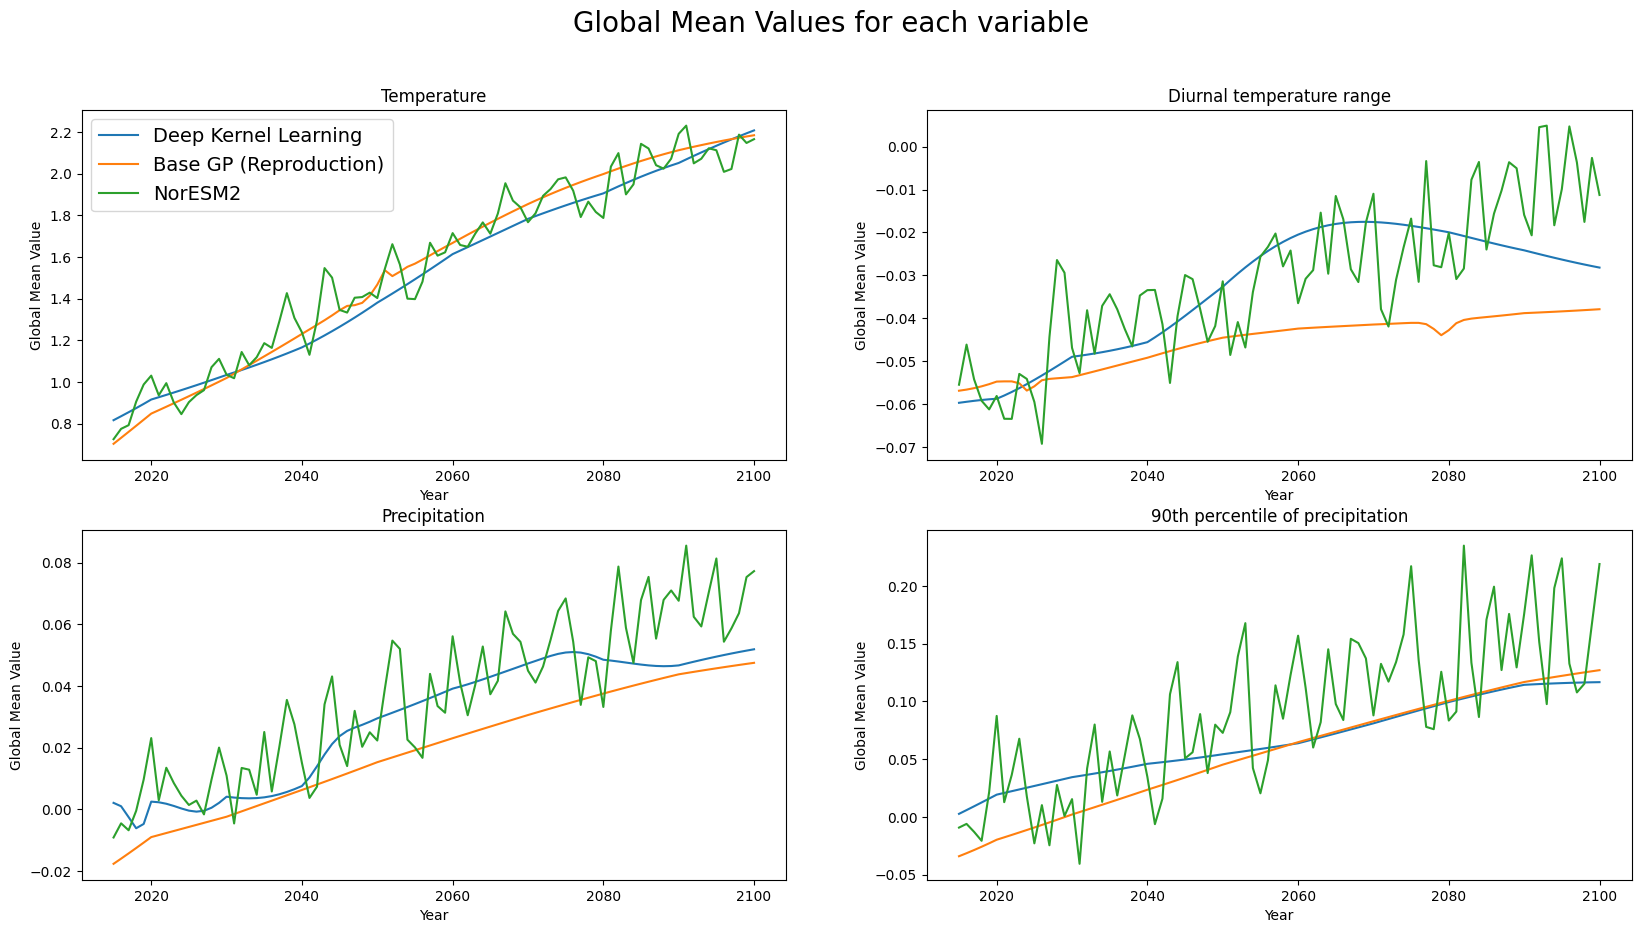

In [13]:
# 4 plots in one figure
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plotting the data
for i, var in enumerate(variables):
    axs = axes.flatten()[i]
    global_mean(gp_means_data[var]).plot(ax=axs, label='Deep Kernel Learning')
    global_mean(gp_means_repo_data[var]).plot(ax=axs, label='Base GP (Reproduction)')
    global_mean(NorESM_data[var]).plot(ax=axs, label='NorESM2')
    axs.set_title(variables_names[i])
    axs.set_ylabel('Global Mean Value')
    axs.set_xlabel('Year')
    if i == 0:
        axs.legend(fancybox=True, fontsize=14)

plt.suptitle('Global Mean Values for each variable', fontsize=20)

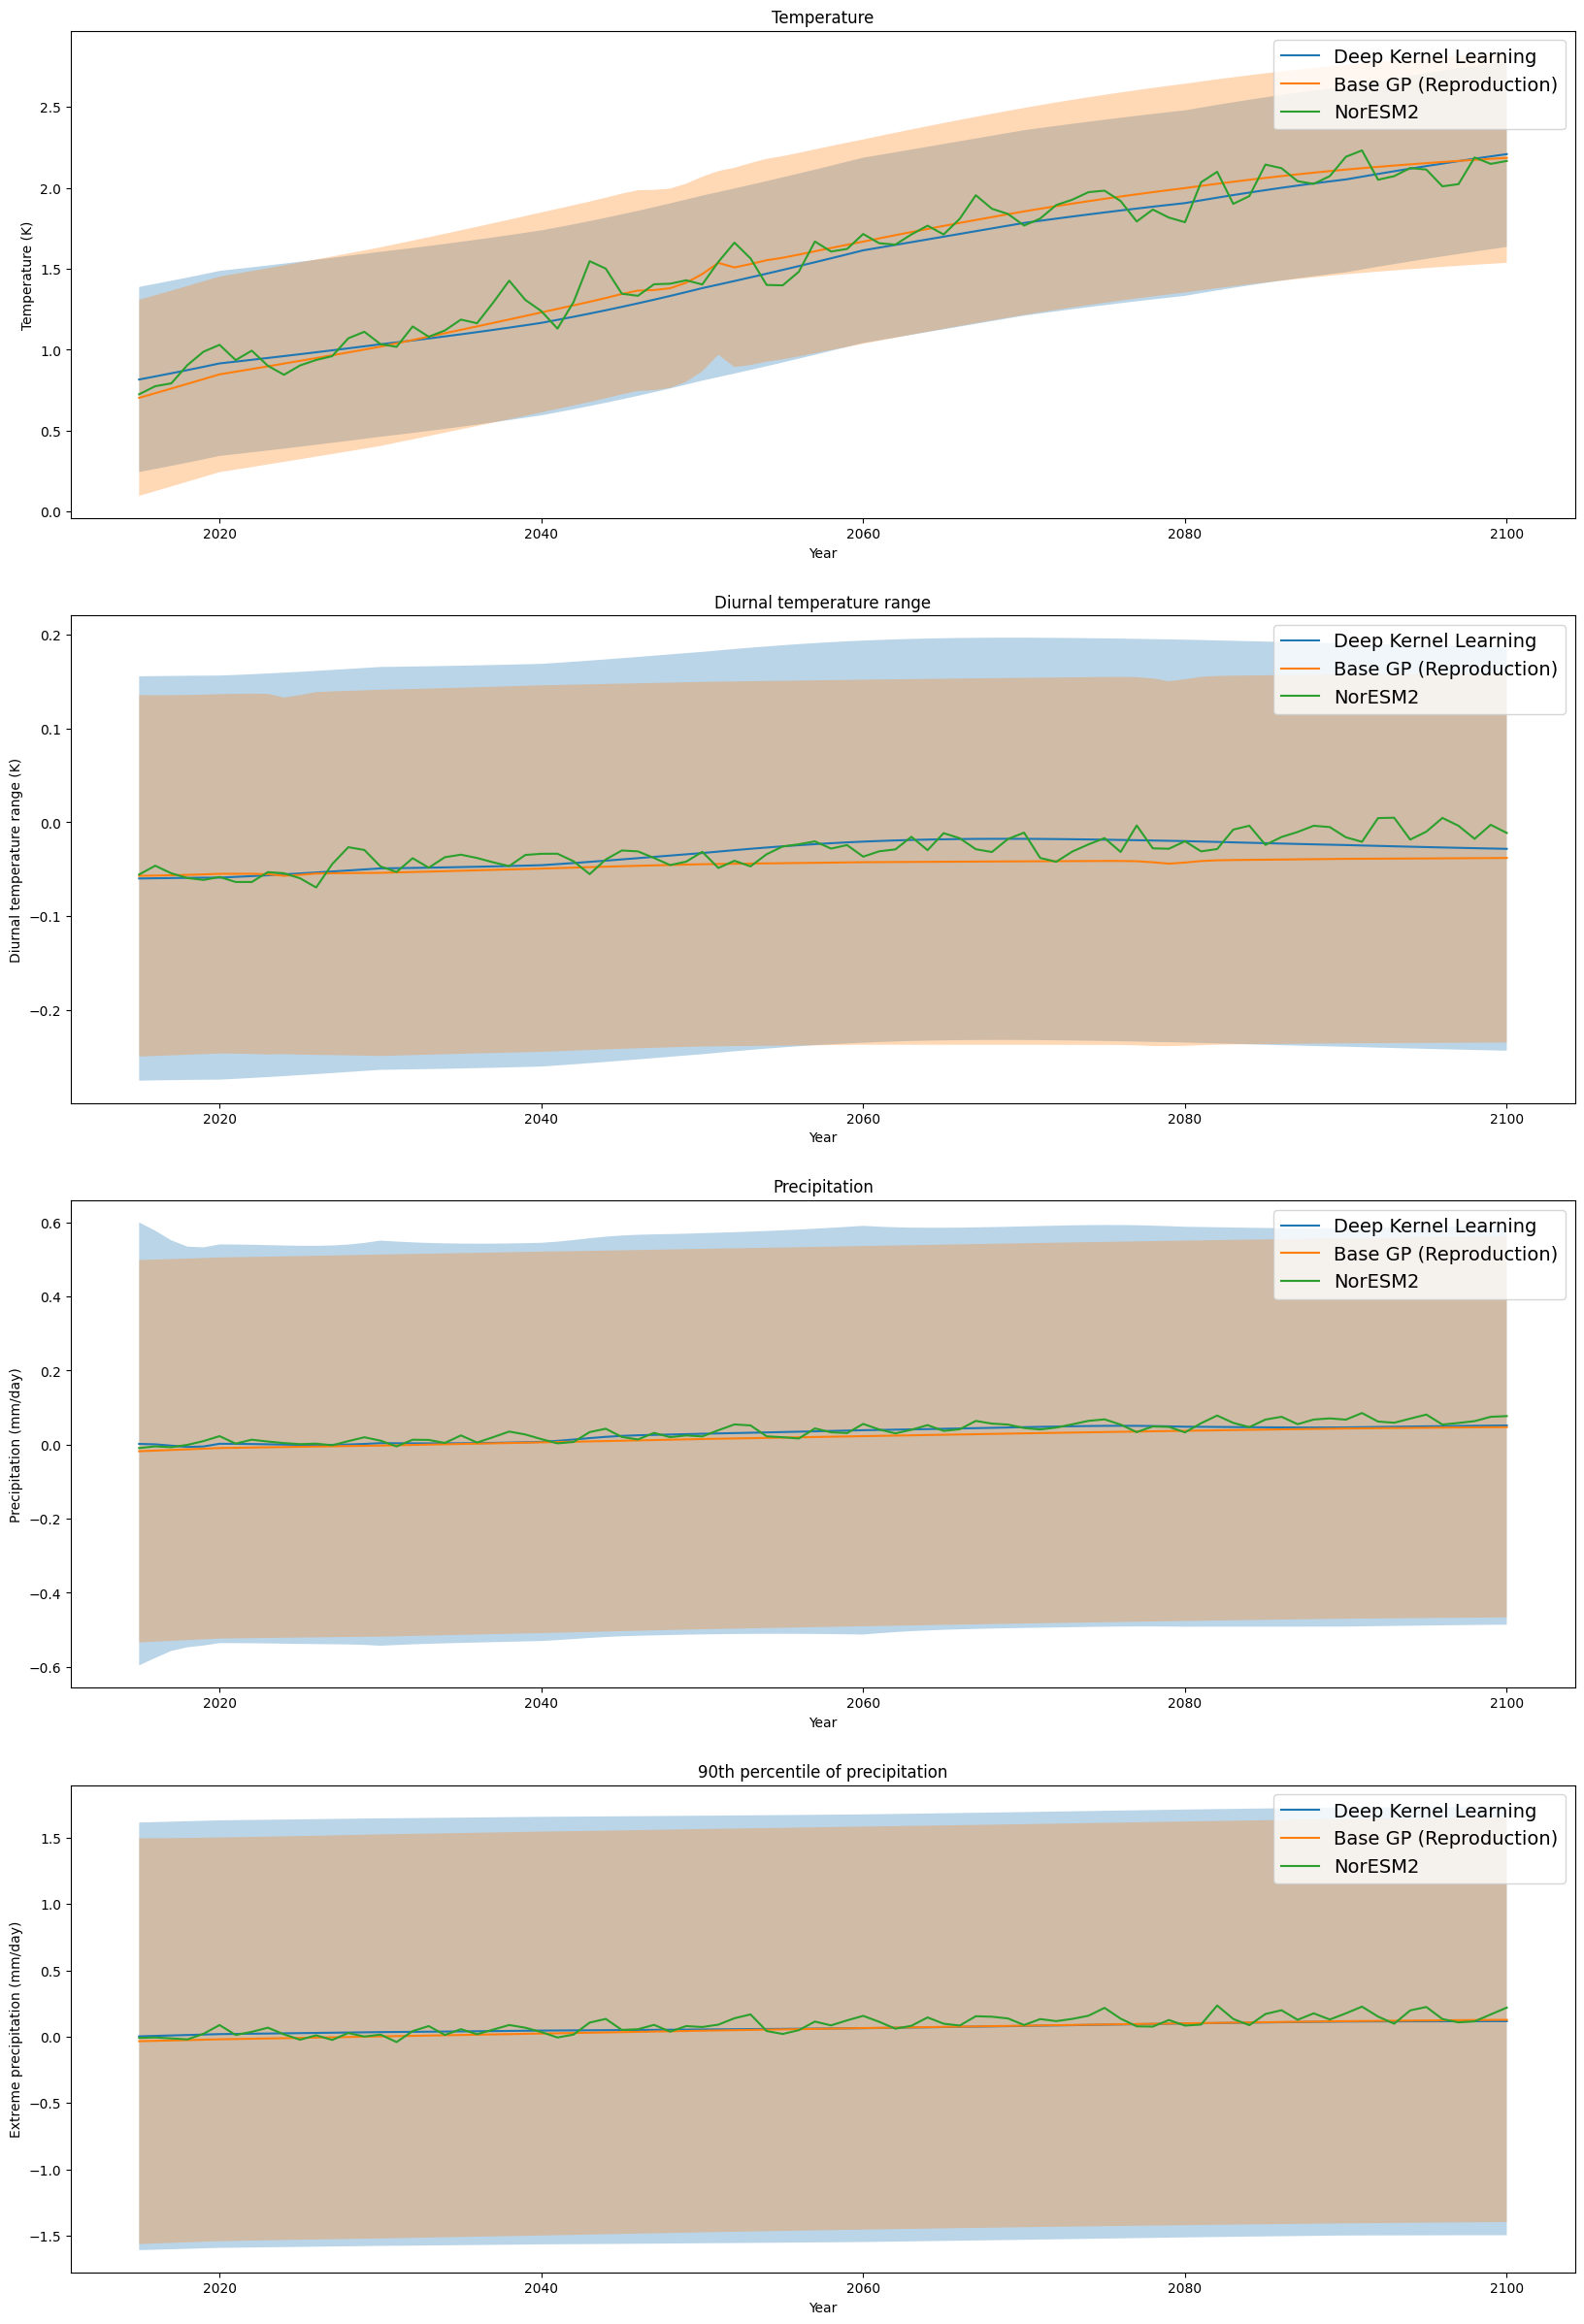

In [14]:
# Plotting time series with uncertainty test with one variable (tas)
fig, axs = plt.subplots(4, 1, figsize=(20, 30))
ylims = [(0.7, 2.4), (-0.07, 0.01), (-0.02, 0.05), (-0.05, 0.2)]

for i, var in enumerate(variables):
    ax = axs[i]
    global_mean(gp_means_data[var]).plot(ax=ax, label='Deep Kernel Learning')
    # ax.set_ylim(ylims[i])
    ax.fill_between(global_mean(gp_means_data[var]).time.data,
                    global_mean(gp_means_data[var] - gp_std_data[var]).data,
                    global_mean(gp_means_data[var] + gp_std_data[var]).data, alpha=0.3)
    
    global_mean(gp_means_repo_data[var]).plot(ax=ax, label='Base GP (Reproduction)')
    ax.fill_between(global_mean(gp_means_repo_data[var]).time.data,
                    global_mean(gp_means_repo_data[var] - gp_std_repo_data[var]).data,
                    global_mean(gp_means_repo_data[var] + gp_std_repo_data[var]).data, alpha=0.3)
    global_mean(NorESM_data[var]).plot(ax=ax, label='NorESM2')
    
    ax.set_title(variables_names[i])
    ax.set_ylabel(labels[i])
    ax.set_xlabel('Year')
    ax.legend(fancybox=True, fontsize=14)
    